In [1]:
# Setup the library
import pyrogue as pr
import os, sys
import matplotlib.pyplot as plt
import time
import numpy as np
import math

top_level=f'{os.getcwd()}/../../..'
pr.addLibraryPath( f'{top_level}/scripts' )
import setupLibPaths
import epix_hr_single_10k

In [2]:
# Create and start the root class
root = epix_hr_single_10k.Root(
    top_level   = top_level,
    sim         = True,
    dev         = '/dev/datadev_1',
    asicVersion = 4,
    pollEn      = False
)
root.start()

Simulation mode : True
justCtrl mode : False
Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)


In [3]:
# Create useful pointers
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

###################################################
#             Firmware Version                    #
###################################################
Path         = ePixHr10kT.Core.AxiVersion
FwVersion    = 0x3010000
UpTime       = 0:00:00
GitHash      = dirty (uncommitted code)
XilinxDnaId  = 0x400000000000000000000001
FwTarget     = EpixHr10kTLclsIITiming
BuildEnv     = Vivado v2023.1
BuildServer  = rdsrv408 (CentOS Linux 7 (Core))
BuildDate    = Thu Nov 21 10:48:20 PST 2024
Builder      = ddoering
###################################################


In [4]:
#Initialze the camera
#[routine, asic0, asic1, asic2, asic3]'
root.EpixHR.InitASIC([4,0,0,0,0])
#points to the ASIC device under test
root.EpixHR.PacketRegisters0.asicDataReq.set(145)
root.EpixHR.PacketRegisters1.asicDataReq.set(145)
root.EpixHR.PacketRegisters0.DisableLane.set(0xfff)
root.EpixHR.PacketRegisters0.EnumerateDisLane.set(0)

Rysync ASIC started
Init ASIC script started
Loading MMCM configuration
/u1/ddoering/localGit/epix-hr-single-10k/software/notebooks/ASIC_V4/pre-proc/../../../yml/ePixHr10kT_MMCM_320MHz.yml
Completed
Loading supply configuration
/u1/ddoering/localGit/epix-hr-single-10k/software/notebooks/ASIC_V4/pre-proc/../../../yml/ePixHr10kT_PowerSupply_Enable.yml
Loading register control (waveforms) configuration
/u1/ddoering/localGit/epix-hr-single-10k/software/notebooks/ASIC_V4/pre-proc/../../../yml/ePixHr10kT_RegisterControl_24us_248MHz.yml
Loading packet registers
Disabling packet lanes for ASIC 0
Disabling packet lanes for ASIC 1
Disabling packet lanes for ASIC 2
Disabling packet lanes for ASIC 3
/u1/ddoering/localGit/epix-hr-single-10k/software/notebooks/ASIC_V4/pre-proc/../../../yml/ePixHr10kT_PacketRegisters.yml
Taking asic off of reset
Loading ASIC and timing configuration
Loading Trigger settings
/u1/ddoering/localGit/epix-hr-single-10k/software/notebooks/ASIC_V4/pre-proc/../../../yml/ePix

In [5]:
root.EpixHR.BatcherEventBuilder2.Bypass.set(1)
root.EpixHR.BatcherEventBuilder2.Blowoff.set(False)


In [21]:
root.EpixHR.TriggerRegisters.StopTriggers()

Stop Triggers command executed


In [23]:
imgRows = 145
imgCols = 384
darkHigh = np.ones((imgRows,imgCols),dtype=np.uint64)*10
darkHigh[:, 10] = np.arange(imgRows)
darkHigh[:,300] = np.arange(imgRows)
darkHigh[0, :] = np.arange(384)
darkHigh[10, :] = np.arange(384)
darkHigh[100, :] = np.arange(384)
darkHigh[110, :] = np.arange(384)
gainHigh = np.ones((imgRows,imgCols),dtype=np.uint64)*0
darkLow  = np.ones((imgRows,imgCols),dtype=np.uint64)*0
gainLow  = np.ones((imgRows,imgCols),dtype=np.uint64)*0

calibParams = root.dummyGen0.setCalibArray(gainLow,darkLow,gainHigh,darkHigh)
root.dummyGen0.testImage = calibParams

In [24]:
root.EpixHR.TriggerRegisters.StopTriggers()
#time.sleep(1)
#HLS
root.EpixHR.DataCorrectionHLS.enable.set(True)
#root.dummyGen0.SendCalibFrame()
print(root.EpixHR.DataCorrectionHLS.HLSAxiLileReg.get())
root.EpixHR.DataCorrectionHLS.HLSAxiLileReg.set(1)
print(root.EpixHR.DataCorrectionHLS.HLSAxiLileReg.get())
# sending frame twice enable calib write
root.dummyGen0.SendCalibFrame()
#time.sleep(5)
#root.dummyGen0.SendCalibFrame()
#root.EpixHR.DataCorrectionHLS.HLSAxiLileReg.set(2)
# sending fram after enables raw data in
#root.dummyGen0.SendCalibFrame()

Stop Triggers command executed
2
1
ibFrame.getPayload() = 445440


In [25]:
root.EpixHR.DataCorrectionHLS.HLSAxiLileReg.get()

1

In [26]:
root.EpixHR.DataCorrectionHLS.HLSAxiLileReg.set(2)

#use system with batcher and missing ASICs
root.EpixHR.SspLowSpeedDecoderReg.enable.set(True)
print ("Locked lanes: %x" % root.EpixHR.SspLowSpeedDecoderReg.Locked.get())
#Only ASIC 1 is available so disable the 6 lower lanes
#root.EpixHR.PacketRegisters0.DisableLane.set(0x3FF)
#root.EpixHR.PacketRegisters1.DisableLane.set(0xFC0)
#using internal triggers, so bypassing timing channel at the batcher 
root.EpixHR.BatcherEventBuilder0.Bypass.set(1)
root.EpixHR.BatcherEventBuilder1.Bypass.set(1)

root.EpixHR.PacketRegisters0.DisableLane.set(0)
root.EpixHR.PacketRegisters1.DisableLane.set(0)
root.EpixHR.RegisterControl.SR0Width1.set(24200)

#Need to confirm clock used for trigger, R0, ACQ and SRO
#Configure waveforms to be 12 and 24 us


root.EpixHR.TriggerRegisters.StopTriggers()
root.EpixHR.RegisterControl.preProcCrtl.set(1);
root.EpixHR.RegisterControl.preProcCrtl.set(0);

In [27]:
root.EpixHR.TriggerRegisters.SetAutoTrigger(4000)
root.EpixHR.TriggerRegisters.StartAutoTrigger()

Set Auto Trigger command executed
Start Auto Trigger command executed


65
(144, 384)
(144, 384)
[   0   -2   -4   -6   -8  -10  -12  -14  -16  -18  -20  -22  -24  -26
  -28  -30  -32  -34  -36  -38  -40  -42  -44  -46  -48  -50  -52  -54
  -56  -58  -60  -62  -64  -66  -68  -70  -72  -74  -76  -78  -80  -82
  -84  -86  -88  -90  -92  -94  -96  -98 -100 -102 -104 -106 -108 -110
 -112 -114 -116 -118 -120 -122 -124 -126    2 -130 -132 -134 -136 -138
 -140 -142 -144 -146 -148 -150 -152 -154 -156 -158 -160 -162 -164 -166
 -168 -170 -172 -174 -176 -178 -180 -182 -184 -186 -188 -190 -192 -194
 -196 -198 -200 -202 -204 -206 -208 -210 -212 -214 -216 -218 -220 -222
 -224 -226 -228 -230 -232 -234 -236 -238 -240 -242 -244 -246 -248 -250
 -252 -254 -256 -258 -260 -262 -264 -266 -268 -270 -272 -274 -276 -278
 -280 -282 -284 -286 -288 -290 -292 -294 -296 -298 -300 -302 -304 -306
 -308 -310 -312 -314 -316 -318 -320 -322 -324 -326 -328 -330 -332 -334
 -336 -338 -340 -342 -344 -346 -348 -350 -352 -354 -356 -358 -360 -362
 -364 -366 -368 -370 -372 -374 -376 -378 -380 -382 -

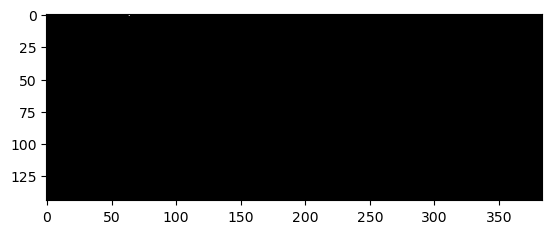

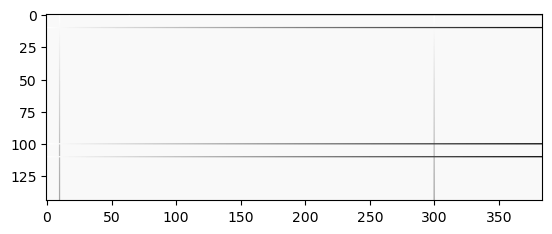

In [28]:
print(root.DataReceiver0.FrameCount.get())
dark = root.DataReceiver0.Data.get()
print(dark.shape)
plt.figure()
plt.imshow(dark, cmap='gray', vmin=0, vmax=20)
plt.plot()

plt.figure()
pre = root.DataReceiver2.Data.get().astype(np.int16)
print(dark.shape)
dark.shape
plt.imshow(pre, cmap='gray', vmin=-800, vmax=0)
plt.plot()
print(pre[0,:])
print(pre[72,:])

In [ ]:
root.EpixHR.PacketRegisters0.EnumerateDisLane.set(0)

In [ ]:
print(root.DataReceiver0.FrameCount.get())
dark = root.DataReceiver0.Data.get()
print(dark.shape)
plt.figure()
plt.imshow(dark, cmap='gray', vmin=0, vmax=20)
plt.plot()

plt.figure()
pre = root.DataReceiver2.Data.get().astype(np.int16)
print(dark.shape)
dark.shape
plt.imshow(pre, cmap='gray', vmin=-400, vmax=20)
plt.plot()

# Helper functions

In [ ]:
def run_asic_test():
    if os.path.isfile(f'{filename}'):   
        os.remove(f'{filename}')    
    print(filename)
    # Setup and open the file writer
    writer = root.dataWriter._writer
    writer.open(f'{filename}')

    # Wait for the file write to open the file
    while( writer.isOpen() is False):
        time.sleep(0.1)

    # Wait a little bit for the file to open up
    time.sleep(1.0)    

    #sets TriggerRegisters
    AcqCount = root.EpixHR.TriggerRegisters.AcqCount.get()
    print("Aquisition Counter " + str(AcqCount))
    root.EpixHR.TriggerRegisters.AutoTrigPeriod.set(50000) #in steps of 10ns
    root.EpixHR.TriggerRegisters.AutoRunEn.set(True)
    root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
    #wait for the camera to get thermally stable
    time.sleep(5.0)    
    root.EpixHR.TriggerRegisters.AutoDaqEn.set(True)
    root.EpixHR.TriggerRegisters.DaqTriggerEnable.set(True)
    initialFrameCounter = writer.getFrameCount()
    # Wait for the file write noise data
    while(writer.getFrameCount() < initialFrameCounter + 4000):
        print( f'Number of frames received: {writer.getFrameCount()}' )
        time.sleep(1)

    # stops triggers
    root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
    time.sleep(0.1)

    # Print the status
    DeltaAcqCount = root.EpixHR.TriggerRegisters.AcqCount.get() - AcqCount
    #print( f'Delta Aquisition Counter: {DeltaAcqCount}')
    print( f'Number of frames received: {writer.getFrameCount()}' )

    # Close the file writer
    writer.close()

    # Wait for the file write to close the file
    while( writer.isOpen() is True):
        time.sleep(0.1)

    ########################################################################################################################3
    f = open(filename, mode = 'rb')
    imgDesc = []
    for i in range(1):
        print("Starting to get data set %d" % (i))
        allFrames = currentCam.getData(f,16)
        imgDesc2 = currentCam.getDescImaData(allFrames)
        if i == 0:
            headers = allFrames[:,0:6]
            imgDesc = imgDesc2
        if i == 1: #skips the first dataset
            headers = allFrames[:,0:6]
            imgDesc = imgDesc2
        else:
            headers = np.concatenate((headers, allFrames[:,0:6]),0)
            imgDesc = np.concatenate((imgDesc, imgDesc2),0)
        if allFrames.shape[0] != MAX_NUMBER_OF_FRAMES_PER_BATCH:
            break


    numberOfFrames = allFrames.shape[0]
    print(allFrames.shape)
    ###########################################################################################################################
    return imgDesc


In [ ]:
def noise_print(offset = 0):
    print(imgDesc[100].shape)
    hg_n  = imgDesc[:,:,offset:offset+192].astype('float64')
    hg_n -= np.median(hg_n, axis=0, keepdims=True)
    hg_n -= np.median(hg_n, axis=(1,2), keepdims=True)
    hg_n -= np.median(hg_n, axis=2, keepdims=True) # rows (cols)
    hg_n -= np.median(hg_n, axis=1, keepdims=True) # cols (rows)
    imgDescCMC = hg_n
    noiseMap = np.std(imgDescCMC,0)
    darkAvg  = np.mean(imgDesc,0)
    
    #noiseMap = np.std(imgDesc[:,:,offset:offset+192],0)
    #darkAvg  = np.mean(imgDesc[:,:,192:384],0)
    medianNoise = np.median(noiseMap)
    plt.figure(1,figsize=(12,8),dpi=150)
    plt.imshow(noiseMap, cmap='gray', vmin=0, vmax=100)
    plt.colorbar(location='right', anchor=(0, 0.3), shrink=0.7)

    plt.figure(2,figsize=(12,8),dpi=150)
    dataset = noiseMap
    plt.hist(dataset.reshape(-1), bins=100, label=f'\nNoise Map distribution AHL, Avg. Dark level w/o CMC %d, Mediam Noise %d' % (np.mean(np.mean(darkAvg)), medianNoise)) 
    plt.yscale('log')
    plt.title("histogram") 
    plt.legend()
    plt.show()
    print()
    return noiseMap, darkAvg

# Pixel Optimizaion

In [ ]:
def setPixel (Preamp = 4, Vld1_b = 1, Pixel_CB = 4, Filter_DAC = 38, VRef_DAC = 53):
    ASIC.Preamp.set(Preamp)
    ASIC.Vld1_b.set(Vld1_b)
    ASIC.Pixel_CB.set(Pixel_CB)
    ASIC.Filter_DAC.set(Filter_DAC)
    ASIC.VRef_DAC.set(VRef_DAC)


    print('Preamp', ASIC.Preamp.get())
    print('Vld1_b',ASIC.Vld1_b.get())
    print('Pixel_CB',ASIC.Pixel_CB.get())
    print('Filter_DAC',ASIC.Filter_DAC.get())
    print('VRef_DAC',ASIC.VRef_DAC.get())

In [ ]:
MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
cameraType            = 'ePixHr10kTBatcher'
bitMask               = 0xffff
currentCam = cameras.Camera(cameraType = cameraType)
currentCam.bitMask = bitMask

In [ ]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)

PreampList = [7,6,5,4,3,2,1,0]
Vld1_b = 0
Pixel_CB= 7
Filter_DAC= 17
VRef_DAC = 58

for Preamp in PreampList:
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)

    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_run1.dat' % (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC))
    ########################################################################################################################
    imgDesc = run_asic_test()
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()

In [ ]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(0.1)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)

Preamp = 7
Vld1_bList = [0, 1, 2, 3]
Pixel_CB= 7
Filter_DAC= 17
VRef_DAC = 58

for Vld1_b in Vld1_bList:
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)

    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V3_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_run1.dat' % (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC))
    ########################################################################################################################
    imgDesc = run_asic_test()
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()

In [ ]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(0.1)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)

Preamp = 7
Vld1_b = 0
Pixel_CBList= [7,6,5,4,3,2,1,0]
Filter_DAC= 17
VRef_DAC = 58

for Pixel_CB in Pixel_CBList:
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)

    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V3_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_run1.dat' % (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC))
    ########################################################################################################################
    imgDesc = run_asic_test()
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()

In [ ]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(0.1)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)

Preamp = 7
Vld1_b = 0
Pixel_CB= 7
Filter_DACList=[7, 13, 15, 17, 19, 21, 27, 37, 47, 57]
VRef_DAC = 58

for Filter_DAC in Filter_DACList:
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)

    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V3_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_run1.dat' % (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC))
    ########################################################################################################################
    imgDesc = run_asic_test()
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()

In [ ]:
Preamp = 7
Vld1_b = 0
Pixel_CB= 7
Filter_DAC= 17
VRef_DACList =[3, 13, 23, 33, 43, 48, 53, 58, 63]

for VRef_DAC in VRef_DACList:
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)

    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V3_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_run1.dat' % (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC))
    ########################################################################################################################
    imgDesc = run_asic_test()
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()

# ADC Optimizaion

In [ ]:
#Set pixels back to default value
ASIC.Preamp.set(4)
ASIC.Vld1_b.set(1)
ASIC.Pixel_CB.set(4)
ASIC.Filter_DAC.set(38)
ASIC.VRef_DAC.set(53)

print('Preamp', ASIC.Preamp.get())
print('Vld1_b',ASIC.Vld1_b.get())
print('Pixel_CB',ASIC.Pixel_CB.get())
print('Filter_DAC',ASIC.Filter_DAC.get())
print('VRef_DAC',ASIC.VRef_DAC.get())

In [ ]:
def setADC (RefGenB = 3, RefGenC = 2, S2D_1_b = 0, shvc_DAC = 23, S2dDacBias = 3):
    ASIC.RefGenB.set(RefGenB) #2 bits
    ASIC.RefGenC.set(RefGenC) #2 bits
    ASIC.S2D_1_b.set(S2D_1_b) #3 bits
    ASIC.shvc_DAC.set(shvc_DAC) #6 bits
    ASIC.S2dDacBias.set(S2dDacBias)
    
    print('RefGenB', ASIC.RefGenB.get())
    print('RefGenC',ASIC.RefGenC.get())
    print('S2D_1_b',ASIC.S2D_1_b.get())
    print('shvc_DAC',ASIC.shvc_DAC.get())
    print('S2dDacBias',ASIC.S2dDacBias.get())

In [ ]:
RefGenBList = [0, 1, 2, 3]
RefGenC = 2
S2D_1_b = 0
shvc_DAC = 23
S2dDacBias = 3
for RefGenB in RefGenBList:
    setADC (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias)

    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u1/ddoering/ePixHR10kTLCLSIITiming_ASICV3_noise_320MHz_RefGenB_%d_All_run1.dat' % RefGenB)
    ########################################################################################################################
    imgDesc = run_asic_test()
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()



In [ ]:
RefGenB = 3
RefGenCList = [0, 1, 2, 3]
S2D_1_b = 0
shvc_DAC = 23
S2dDacBias = 3
for RefGenC in RefGenCList:
    setADC (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias)

    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u1/ddoering/ePixHR10kTLCLSIITiming_ASICV3_noise_320MHz_RefGenC_%d_All_run1.dat' % RefGenC)
    ########################################################################################################################
    imgDesc = run_asic_test()
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()


In [ ]:
RefGenB = 3
RefGenC = 2
S2D_1_bList = [0, 1, 2, 3, 4, 5, 6, 7]
shvc_DAC = 23
S2dDacBias = 3
for S2D_1_b in S2D_1_bList:
    setADC (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias)

    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u1/ddoering/ePixHR10kTLCLSIITiming_ASICV3_noise_320MHz_S2D_1_b_%d_All_run1.dat' % S2D_1_b)
    ########################################################################################################################
    imgDesc = run_asic_test()
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()

In [ ]:
RefGenB = 3
RefGenC = 2
S2D_1_b = 0
shvc_DACList = [3, 13, 23, 33, 43, 53, 63]
S2dDacBias = 3
for shvc_DAC in shvc_DACList:
    setADC (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias)

    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u1/ddoering/ePixHR10kTLCLSIITiming_ASICV3_noise_320MHz_shvc_DAC_%d_All_run1.dat' % shvc_DAC)
    ########################################################################################################################
    imgDesc = run_asic_test()
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()

In [ ]:
RefGenB = 3
RefGenC = 2
S2D_1_b = 0
shvc_DAC = 23
S2dDacBiasList = [0, 1, 2, 3, 4, 5, 6, 7]
for S2dDacBias in S2dDacBiasList:
    setADC (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias)

    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u1/ddoering/ePixHR10kTLCLSIITiming_ASICV3_noise_320MHz_S2dDacBias_%d_All_run1.dat' % S2dDacBias)
    ########################################################################################################################
    imgDesc = run_asic_test()
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()

# Custom settings, repeat latest 10kA

In [ ]:
Preamp = 4
Vld1_b = 1
Pixel_CB= 4
Filter_DAC=17
VRef_DAC =19


setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)

######################################################################################################################
# Remove previous dataset
filename = (f'/u1/ddoering/ePixHR10kTLCLSIITiming_ASICV3_noise_320MHz_10ka_settings_All_run1.dat')
########################################################################################################################
imgDesc = run_asic_test()
########################################################################################################################
[noiseMap, darkAvg] = noise_print()


In [ ]:
Preamp = 6
Vld1_b = 1
Pixel_CB= 4
Filter_DAC=17
VRef_DAC =53


setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)

######################################################################################################################
# Remove previous dataset
filename = (f'/u1/ddoering/ePixHR10kTLCLSIITiming_ASICV3_noise_320MHz_10ka_settings_Preamp_%d_VrefDAC_%d_All_run1.dat' % (Preamp , VRef_DAC))
########################################################################################################################
imgDesc = run_asic_test()
########################################################################################################################
[noiseMap, darkAvg] = noise_print()